In [11]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba 
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
import bz2

ImportError: DLL load failed: 找不到指定的程序。

词向量使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的"chinese-word-vectors"
https://github.com/Embedding/Chinese-Word-Vectors

In [ ]:
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [ ]:
#使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram', 
                                             binary=False, unicode_errors="ignore")
#在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量

LSTM神经网络模型并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量。

In [ ]:
embedding_dim = cn_model['华中师范大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['华中师范大学']

In [ ]:
# 将所有的评价内容放置到一个list里，并设置格式为utf8
train_texts_orig = []
# 文本所对应的labels, 也就是标记
train_target = []
with open("positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

对应的语料文件是"negative_samples.txt", "positive_samples.txt"这两个

In [ ]:
len(train_texts_orig)

In [ ]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

进行分词和tokenize

In [ ]:
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [ ]:
train_tokens

In [ ]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
plt.hist(num_tokens, bins = 100)
plt.xlim((0,400))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

In [ ]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [ ]:
reverse = reverse_tokens(train_tokens[0])

In [ ]:
reverse

In [ ]:
# 原始文本
train_texts_orig[0]

准备Embedding Matrix
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为 (𝑛𝑢𝑚𝑤𝑜𝑟𝑑𝑠,𝑒𝑚𝑏𝑒𝑑𝑑𝑖𝑛𝑔𝑑𝑖𝑚) 的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。
注意我们只选择使用前100k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [ ]:
embedding_dim

In [ ]:
# 只使用前100k个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [ ]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

In [ ]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

In [ ]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [ ]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

In [ ]:
# 准备target向量，前2000样本为1，后2000为0
train_target = np.array(train_target)

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [2]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

NameError: name 'reverse_tokens' is not defined

In [3]:
# 用LSTM对样本进行分类
model = Sequential()

# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

NameError: name 'Sequential' is not defined

In [4]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [5]:
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

NameError: name 'model' is not defined

In [6]:
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)

NameError: name 'model' is not defined

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [8]:
model.summary()

NameError: name 'model' is not defined

In [34]:
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [35]:
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [36]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [37]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [38]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [39]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=100,
          batch_size=128,
          callbacks=callbacks)

Train on 3240 samples, validate on 360 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3200/3240 [============================>.] - ETA: 1s - loss: 0.2946 - acc: 0.8819
Epoch 00001: val_loss improved from inf to 0.30436, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 108s 33ms/sample - loss: 0.2944 - acc: 0.8824 - val_loss: 0.3044 - val_acc: 0.8861
Epoch 2/100
3200/3240 [============================>.] - ETA: 1s - loss: 0.2470 - acc: 0.8978
Epoch 00002: val_loss did not improve from 0.30436

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3240/3240 [==============================] - 108s 33ms/sample - loss: 0.2474 - acc: 0.8975 - val_loss: 0.3418 - val_acc: 0.8583
Epoch 3/100
3200/3240 [============================>.] - ETA: 1s - loss: 0.2227 - acc: 0.9181
Epoch 00003: val_loss improved from 0.30436 to 0.29723, saving model to sentiment_checkpoint.keras
3240/3240 [=============================

In [40]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))
#准确率

400/400 [==============================] - 5s 11ms/sample - loss: 0.3356 - acc: 0.8675
Accuracy:86.75%


In [41]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [42]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.14
酒店卫生条件非常不好
是一例负面评价 output=0.10
床铺非常舒适
是一例正面评价 output=0.82
房间很凉，不给开暖气
是一例负面评价 output=0.27
房间很凉爽，空调冷气很足
是一例正面评价 output=0.75
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.06
房间隔音不到位
是一例负面评价 output=0.32
晚上回来发现没有打扫卫生
是一例负面评价 output=0.29
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.11


错误分类的文本 经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性，如index为101的这个句子，好像没有一点满意的成分，但这例子评价在训练样本中被标记成为了正面评价，而我们的模型做出的负面评价的预测似乎是合理的。

In [43]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [44]:
y_actual = np.array(y_test)
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [45]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

400


In [16]:
import matplotlib.pyplot as plt
import jieba
from wordcloud import WordCloud

In [23]:
file = open("posresult_jieba.txt", 'r',encoding="utf-8")
text1 = file.read()
file.close()
file = open("negresult_jieba.txt", 'r',encoding="utf-8")
text2 = file.read()
file.close()

In [24]:
text1

'早餐 太 差 ， 无论 去 多少 人 ， 那边 也 不加 食品 的 。 酒店 应该 重视 一下 这个 问题 了 。 \n \n 房间 本身 很 好 。 \n \n \n \n \n 宾馆 在 小 街道 上 ， 不大好 找 ， 但 还好 北京 热心 同胞 很多 ~ \n \n 宾馆 设施 跟 介绍 的 差不多 ， 房间 很小 ， 确实 挺 小 ， 但 加上 低价位 因素 ， 还是 无超 所值 的 ； \n \n 环境 不错 ， 就 在 小 胡同 内 ， 安静 整洁 ， 暖气 好足 - _ - | | 。 。 。 呵 \n \n 还有 一大 优势 就 是从 宾馆 出发 ， 步行 不到 十分钟 就 可以 到 梅兰芳 故居 等等 ， 京味 小 胡同 ， 北海 距离 好近 呢 。 \n \n 总之 ， 不错 。 \n \n 推荐 给 节约 消费 的 自助游 朋友 ~ 比较 划算 ， 附近 特色小吃 很多 ~ \n \n \n \n \n CBD 中心 , 周围 没什么 店铺 , 说 5 星 有点 勉强 . 不 知道 为什么 卫生间 没有 电吹风 \n \n \n \n \n 总的来说 ， 这样 的 酒店 配 这样 的 价格 还 算 可以 ， 希望 他 赶快 装修 ， 给 我 的 客人 留些 好 的 印象 \n \n \n \n \n 价格比 比较 不错 的 酒店 。 这次 免费 升级 了 ， 感谢 前台 服务员 。 房子 还好 ， 地毯 是 新 的 ， 比 上次 的 好些 。 早餐 的 人 很多 要 早 去 些 。 \n \n \n \n \n \n \n \n \n 不错 ， 在 同等 档次 酒店 中 应该 是 值得 推荐 的 ！ \n \n \n \n \n 入住 丽晶 ， 感觉 很 好 。 因为 是 新 酒店 ， 的确 有 淡淡的 油漆味 ，   房间内 较 新 。 房间 大小 合适 ， 卫生间 设备齐全 ， 服务态度 也 很 好 。 网速 可能 是 提升 了 吧 ， 感觉 还好 。 有 免费 的 插 线板 、 水果刀 。 。 。 等 一系列 的 日常用品 免费 提供 ， 很 细心 。 晚上 的 自助餐 是 每人 68 元 ， 菜品 一般 、 就算 说 的 过去 吧 。 酒店 外有 西贝筱面 等 几家 饭馆 。 西贝 的 菜 实在 是 量 大 的 惊人 ， 人多 在 

In [25]:
# text_positive = open(r'posresult_jieba.txt', "r",encoding="utf-8").read()
# text_negative = open(r'negresult_jieba.txt', "r",encoding="utf-8").read()

stop_words = open("./stop_words.txt", 'r',encoding="utf-8").read()
ceshi = open("./ceshi.txt", 'r',encoding="utf-8").read()
import re

text_list1 = text1.split(" ")
stop_words_list = stop_words.split("\n")
final_text_list1 = ''
for seg in text_list1:
    if not ((seg in stop_words_list) or re.search(r"^\S$", seg)): # 不在stopwords_list, 同时不是单字节
            final_text_list1 += seg
            final_text_list1 += " " 
            
text_list2 = text2.split(" ")
stop_words_list = stop_words.split("\n")
final_text_list2 = ''
for seg in text_list2:
    if not ((seg in stop_words_list) or re.search(r"^\S$", seg)): # 不在stopwords_list, 同时不是单字节
            final_text_list2 += seg
            final_text_list2 += " " 
            


In [26]:
final_text_list1

'早餐 不加 食品 酒店 应该 重视 问题 \n \n 房间 本身 \n \n \n \n \n 宾馆 街道 北京 热心 同胞 很多 \n \n 宾馆 设施 介绍 房间 很小 确实 加上 低价位 因素 无超 所值 \n \n 环境 不错 胡同 安静 整洁 暖气 好足 \n \n 一大 优势 是从 宾馆 出发 步行 十分钟 梅兰芳 故居 京味 胡同 北海 距离 好近 \n \n 不错 \n \n 推荐 节约 消费 自助游 朋友 比较 划算 附近 特色小吃 很多 \n \n \n \n \n CBD 中心 周围 店铺 勉强 知道 卫生间 电吹风 \n \n \n \n \n 酒店 价格 希望 赶快 装修 客人 留些 印象 \n \n \n \n \n 价格比 比较 不错 酒店 免费 升级 感谢 前台 服务员 房子 地毯 早餐 很多 \n \n \n \n \n \n \n \n \n 不错 同等 档次 酒店 应该 值得 推荐 \n \n \n \n \n 入住 丽晶 感觉 酒店 的确 淡淡的 油漆味 房间内 房间 大小 合适 卫生间 设备齐全 服务态度 网速 提升 感觉 免费 线板 水果刀 一系列 日常用品 免费 提供 细心 晚上 自助餐 每人 68 菜品 就算 过去 酒店 外有 西贝筱面 饭馆 西贝 实在 惊人 人多 酒店 不如 西贝 酒店 21 30 24 点有 广式 晚茶 味道 正宗 点心 品种 略少 \n \n 酒店 地处 青山区 包头 分昆区 青山区 相对来说 昆区 繁华 青山区 次之 包百等 商场 全在 昆区 酒店 打车 包百 商圈 车费 12 元多 青山区 一个 王府井 百货 相对来说 包百 商圈 酒店 打车 元多 银河 广场 酒店 一段距离 打车 10 银河 广场 边上 科丽珑 24 小时 营业 超市 酒店 一楼 小卖部 周围 基本 超市 \n \n 正赶上 公司 开会 楼道 里略 晚上 有人 错门 理论 酒店 管理 没关系 希望 尽量 会议 团体 一层 也许 总体 感觉 丽晶 包头 还会 \n \n \n \n \n 酒店 比较 装潢 设施 不错 房间 油漆味 \n \n 早餐 品种 不是 很多 \n \n 交通 比较 方便 周围 饭店 比较 \n \n \n \n \n 特色 标间 特色 类似 感觉 寝具 不是 单调 白色 条纹 格子 感觉 温馨 圈

In [27]:
final_text_list2

'标准间 房间 不如 设施 非常 陈旧 建议 酒店 标准间 改善 \n \n \n \n \n 服务态度 极其 前台 接待 好象 受过 培训 基本 礼貌 竟然 接待 客人 \n \n 大堂 副理 客人 辩解 没完 总经理 电话 投诉 竟然 不敢 亏心事 跟本 \n \n \n \n \n \n \n \n \n 地理位置 不错 比较 方便 \n \n 服务 象是 豪生 集团 管理 比较 \n \n 下午 一觉 一个 酒店 打扫 打开 打扫 服务 晚上 酒店 发现 打扫 服务 关掉 房间 打扫 \n \n \n \n \n \n \n \n \n 次住 长春 雁鸣 大酒店 昨晚 夜里 停电 深夜 睡着 钱包 进入 房间 1000 信用卡 \n \n 证件 外币 数码相机 房间 保险箱 原封不动 好几个 小时 长途电话 处理 信用卡 冻结 报案 酒店 保安 摄像 探头 竟然 修理 \n \n 保安 查房 入门 时间 其他人 深夜 进入 房间 高明 方式 进入 羽绒服 放在 地上 醒来时 多想 中午 发觉 钱包 现金 信用卡 \n \n 这家 酒店 态度 很差 同情心 之前 授权 2000 国际 电话 银行 两天 我入 酒店 2000 授权 酒店 财务 不领情 中国银行 授权 国际 电话 银行 \n \n 这家 星级 酒店 负责 认为 发生 报案 不住 服务态度 可耻 \n \n 事件 想定 酒店 住客 酒店 停电 摄像头 凑巧 大家 知道 这种 行为 强力 打击 \n \n 千元 小事 酒店 处理 态度 反感 强力 告诉 大家 提醒 其他人 不要 酒店 \n \n \n \n \n 前台 check in 20 分钟 check out 25 分钟 服务态度 做到 \n \n 信用卡 愿意 手工 打电话 授权 典型 国营企业 极差 服务态度 \n \n \n \n \n 沒有 很少 無煙 房間 電梯 內部 不許 吸煙 還有 一些 吸煙者 沒有服 規則 抽煙 成為 二手 受害者 中國 13 人口 煙民 3.2 看到 這條 評論 煙民 自覺 謝謝 \n \n \n \n \n \n \n \n \n 酒店 服务态度 极差 设施 很差 建议 不要 \n \n \n \n \n 3.6 预定 180 标间 竟然 会议 房间 我订 房间 信誉 再也不会 \n \n \n \n \

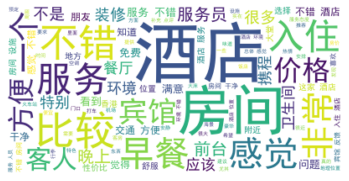

In [36]:
result1 = ''.join(final_text_list1)
wc = WordCloud(
    font_path="C:/Windows/Fonts/simhei.ttf",
    background_color="white",
    max_words=100,
    max_font_size=80
).generate(result1)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
wc.to_file('pos_cloud.png')

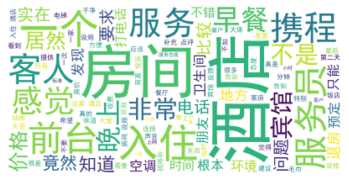

In [35]:
result2 = ''.join(final_text_list2)
wc = WordCloud(
    font_path="C:/Windows/Fonts/simhei.ttf",
    background_color="white",
    max_words=100,
    max_font_size=80
).generate(result2)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
wc.to_file('neg_cloud.png')